# **Detection**

**Subsections:**
- **Pre-processing:** `BackgroundSubtractorMOG2`
- **Processing:** `HoughCircle`
- **Post-processing**

In [21]:
# Import required libraries
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Loading the video file

- _notebook_dir -> /home/davic/projects/IACV_project/bowling-analysis/notebook/ball_detection_
- _project_root -> /home/davic/projects/IACV_project/bowling-analysis_
- _video_path   -> /home/davic/projects/IACV_project/bowling-analysis/data/recording_2/Recording_2_normal_speed.mp4_

In [22]:
video_number = "5"
PROJECT_ROOT = Path().resolve().parent.parent
INPUT_VIDEO_PATH = str(PROJECT_ROOT / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4")
INPUT_CSV_PATH = str(PROJECT_ROOT / "data" / "auxiliary_data" / "lane_points" / f"lane_points_raw_{video_number}.csv")

# Load the video
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 30.0, Total Frames: 258.0


## Pre-processing

Auxiliary functions

In [23]:
# Function to display an image
def showImage(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

I read one frame in order to test the techniques

In [24]:
frame_index = 130 # frame to test
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
ret, frame = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

**Techniques for pre-processing**

For Recording_3 I have tryed:

- `bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=450, varThreshold=20, detectShadows=True)`
- `bg_subtractor.setVarThresholdGen(35)`

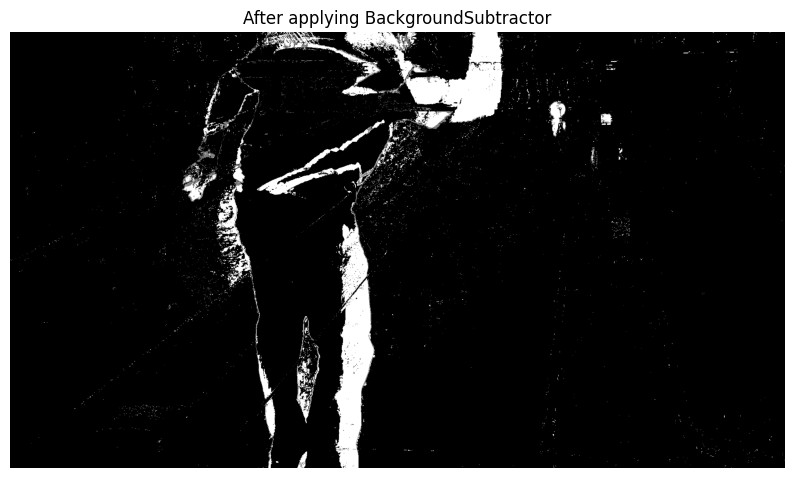

In [25]:
# Initialize background subtractor
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)
bg_subtractor.setVarThresholdGen(25)

'''
history ->  Higher value → More stable background model (good for static scenes).
            Lower value → Faster adaptation to changes (good for dynamic scenes).
varThreshold -> Higher value → Only very different pixels are considered foreground.
                Lower value → More sensitive to small changes (can lead to noise).
varThresholdGen ->  Higher value → Background adapts slower.
                    Lower value → Background adapts faster.
'''

# Reset the cap to the initial frame
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Warm-up: Read first n-40 frames to build the background model
for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))-40):
    ret, frame_bg = cap.read()
    if not ret: break
    bg_subtractor.apply(frame_bg)

# Apply background subtraction
fg_mask = bg_subtractor.apply(frame)

showImage(fg_mask, "After applying BackgroundSubtractor")

In [26]:
def remove_background(frame_count, input_points, image):
    # Read the specific row for this frame
    df = pd.read_csv(input_points)
    row = df[df['Frame'] == frame_count]

    if row.empty:
        raise ValueError(f"No points found for frame {frame_count}")

    # Extract the four points
    points = np.array([
        [row['bottom_left_x'].values[0], row['bottom_left_y'].values[0]],
        [row['bottom_right_x'].values[0], row['bottom_right_y'].values[0]],
        [row['up_right_x'].values[0], row['up_right_y'].values[0]],
        [row['up_left_x'].values[0], row['up_left_y'].values[0]],
    ], dtype=np.int32)

    # Find indices of top two points (min Y)
    y_values = points[:, 1]
    top_indices = np.argsort(y_values)[:2]
    top_points = points[top_indices]

    # Determine left and right among the top points
    if top_points[0][0] < top_points[1][0]:
        left_top = top_points[0]
        right_top = top_points[1]
    else:
        left_top = top_points[1]
        right_top = top_points[0]

    # Apply the shifts
    left_top_mod = np.array([left_top[0] - 50, left_top[1] - 70])
    right_top_mod = np.array([right_top[0] + 50, right_top[1] - 70])

    # Replace the original top points in the array
    modified_points = []
    for i, pt in enumerate(points):
        if np.array_equal(pt, left_top):
            modified_points.append(left_top_mod)
        elif np.array_equal(pt, right_top):
            modified_points.append(right_top_mod)
        else:
            modified_points.append(pt)

    modified_points = np.array(modified_points, dtype=np.int32)

    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [modified_points], 255)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

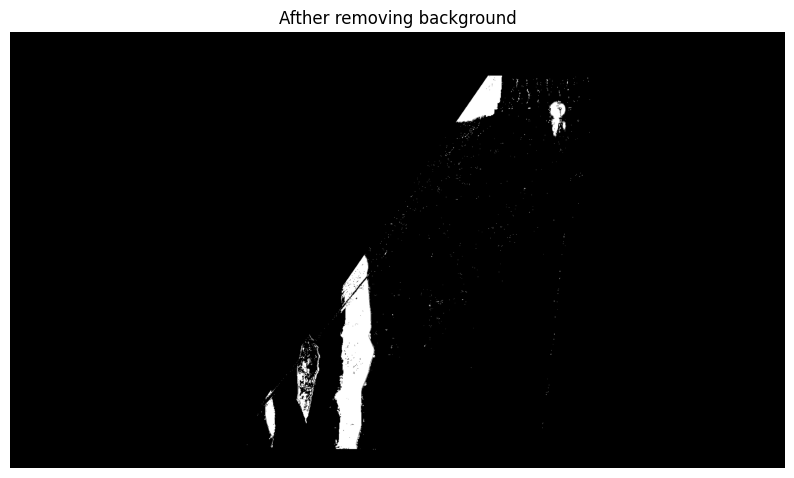

In [27]:
clean_image = remove_background(frame_index, INPUT_CSV_PATH, fg_mask)
showImage(clean_image, "Afther removing background")

In [28]:
cap.release()

## Processing

Min: 12, Max: 55


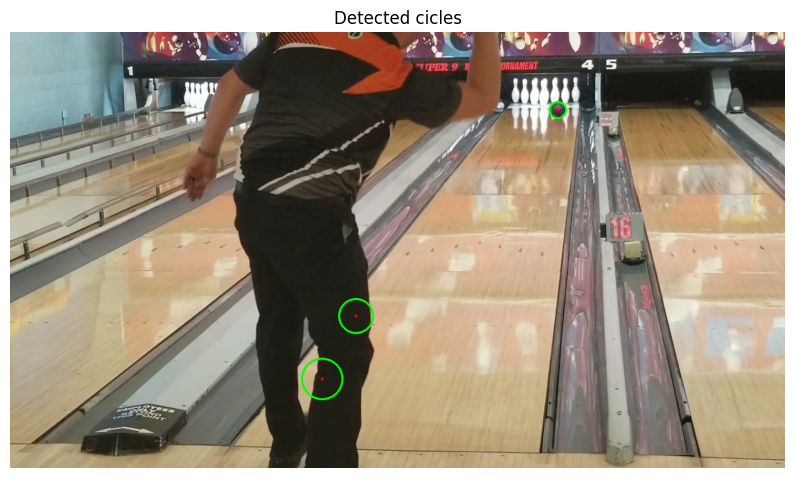

In [29]:
min = int((total_frames - frame_index)*0.10 + 0)                       # TODO: change with more accuracy
max = int((total_frames - frame_index)*0.20 + 30)                       # TODO: change with more accuracy
print(f"Min: {min}, Max: {max}")

# Hough Circle Detection
circles = cv2.HoughCircles(
    clean_image, 
    cv2.HOUGH_GRADIENT, 
    dp=1.2,  # Inverse ratio of resolution
    minDist=100,  # Minimum distance between detected centers
    param1=50,  # Higher threshold for Canny edge detector
    param2=30,  # Accumulator threshold for circle detection
    minRadius=min,  # Minimum radius of detected circles
    maxRadius=max   # Maximum radius of detected circles
)

# Draw circles if detected
if circles is not None:
    circles = np.uint16(np.around(circles))
    output = frame.copy()
    for i in circles[0, :]:
        cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 3)  # Draw circle
        cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)  # Draw center

    showImage(output, "Detected cicles")
else:
    print("No circles detected")


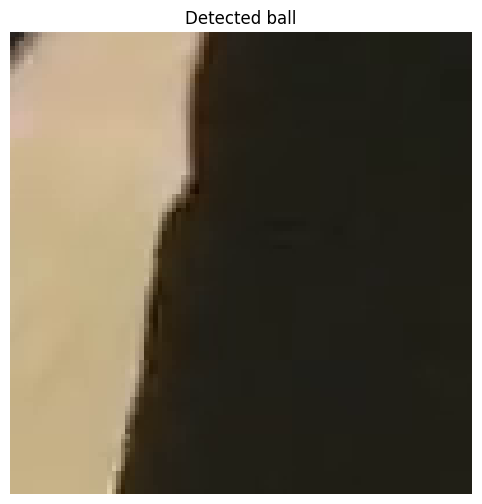

In [30]:
if circles is not None:
    x, y, r = circles[0, 0]  # Get first detected circle
    ball = frame[y-r:y+r, x-r:x+r]  # Crop the ball region
    if ball.size > 0:
        showImage(ball, "Detected ball")